In [77]:
import os
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
# from torch_scatter import scatter_mean
from torch_geometric.utils import to_networkx

os.environ['TORCH_VERSION'] = torch.__version__
print(torch.__version__)

2.0.1


In [76]:
!echo $TORCH_VERSION

2.0.1


In [8]:
# 行にエッジに端点、列にエッジを表す
# 0 -> 1, 1 -> 0, 1 -> 2, 2 -> 1（各数字はノード番号）
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

In [25]:
print(data.keys)
print(data['x'])
print(data['edge_index'])
print(f"num_nodes: {data.num_nodes}")
print(f"num_edges: {data.num_edges}")
print(f"num_node_features: {data.num_node_features}")
print(f"has_isolated_nodes: {data.has_isolated_nodes()}")
print(f"has_self_loops: {data.has_self_loops()}")
# 有向グラフかどうか
print(f"is_directed: {data.is_directed()}")

['edge_index', 'x']
tensor([[-1.],
        [ 0.],
        [ 1.]])
tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
num_nodes: 3
num_edges: 4
num_node_features: 1
has_isolated_nodes: False
has_self_loops: False
is_directed: False


In [52]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

In [34]:
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

data = dataset[0]
print(data)
# 無向グラフ
print(data.is_undirected())

# Data(edge_index=[2, 168], x=[37, 3], y=[1])
# 37個のノード、3次元の特徴量、168/2個のエッジ

600
6
3
Data(edge_index=[2, 168], x=[37, 3], y=[1])
True


In [36]:
perm = torch.randperm(len(dataset))
dataset = dataset[perm]

In [37]:
train_dataset = dataset[:540]
test_dataset = dataset[540:]

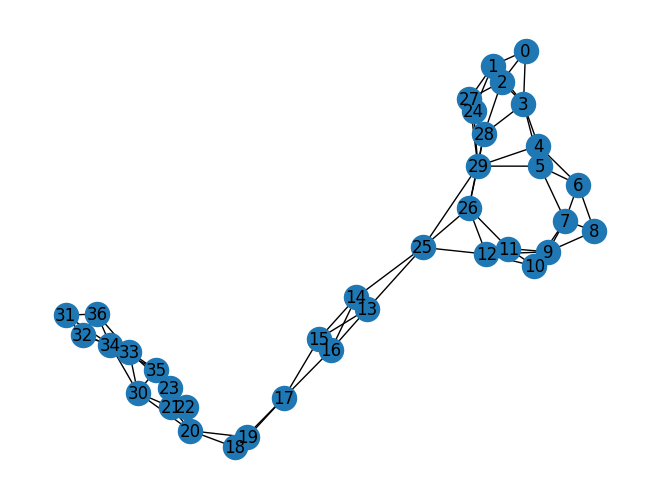

In [56]:
def visualize(data):
    g = to_networkx(data, to_undirected=True)
    nx.draw(g, with_labels=True)

visualize(dataset[0])

In [45]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset

Processing...
Done!


Cora()

In [47]:
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

1
7
1433


In [57]:
data = dataset[0]
data

# Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
# 2708個のノード、1433次元の特徴量、10556/2個のエッジ, 2708個のラベル

Data(edge_index=[2, 168], x=[37, 3], y=[1])

In [59]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

/Users/shuomura/Library/Caches/pypoetry/virtualenvs/ml-sandbox-br58J_x6-py3.11/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [71]:
for batch in loader:
    print(batch, end="   ")
    print(batch.num_graphs)

DataBatch(edge_index=[2, 4098], x=[1101, 21], y=[32], batch=[1101], ptr=[33])   32
DataBatch(edge_index=[2, 4198], x=[1067, 21], y=[32], batch=[1067], ptr=[33])   32
DataBatch(edge_index=[2, 3590], x=[898, 21], y=[32], batch=[898], ptr=[33])   32
DataBatch(edge_index=[2, 3958], x=[1059, 21], y=[32], batch=[1059], ptr=[33])   32
DataBatch(edge_index=[2, 4132], x=[1073, 21], y=[32], batch=[1073], ptr=[33])   32
DataBatch(edge_index=[2, 4114], x=[1036, 21], y=[32], batch=[1036], ptr=[33])   32
DataBatch(edge_index=[2, 3330], x=[865, 21], y=[32], batch=[865], ptr=[33])   32
DataBatch(edge_index=[2, 3786], x=[1031, 21], y=[32], batch=[1031], ptr=[33])   32
DataBatch(edge_index=[2, 3624], x=[937, 21], y=[32], batch=[937], ptr=[33])   32
DataBatch(edge_index=[2, 4052], x=[1042, 21], y=[32], batch=[1042], ptr=[33])   32
DataBatch(edge_index=[2, 3936], x=[983, 21], y=[32], batch=[983], ptr=[33])   32
DataBatch(edge_index=[2, 4812], x=[1261, 21], y=[32], batch=[1261], ptr=[33])   32
DataBatch(ed

In [78]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [111]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()

Net(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [113]:
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
acc

0.8